In [1]:
import bt

%matplotlib inline
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_ta
import seaborn as sns
import talib
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from skopt.plots import plot_evaluations, plot_objective

C:\Users\murat\AppData\Roaming\Python\Python39\site-packages\backtesting\_plotting.py:47: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
data = yf.download(tickers="ISCTR.IS", period="max", interval="5m", start="2021-07-20")
data.drop(["Close"], axis=1, inplace=True)
data.rename(columns={"Adj Close": "Close"}, inplace=True)
data.index = pd.DatetimeIndex(data.index.strftime("%Y-%m-%d %H:%M:%S"))
data.index.name = "Date"
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-07-26 09:55:00,5.12,5.12,5.12,5.12,0
2021-07-26 10:00:00,5.12,5.13,5.12,5.13,835087
2021-07-26 10:05:00,5.13,5.13,5.12,5.13,170274
2021-07-26 10:10:00,5.13,5.13,5.12,5.12,327272
2021-07-26 10:15:00,5.12,5.13,5.11,5.12,863521
...,...,...,...,...,...
2021-09-03 17:05:00,5.68,5.69,5.67,5.69,330852
2021-09-03 17:10:00,5.69,5.69,5.68,5.69,292943
2021-09-03 17:15:00,5.69,5.69,5.68,5.68,202552


In [3]:
# Simple SMA Strategy
class SmaCross(Strategy):

    n1 = 5
    n2 = 8

    def init(self):
        self.sma1 = self.I(talib.SMA, self.data.Close, self.n1)
        self.sma2 = self.I(talib.SMA, self.data.Close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()


bt = Backtest(data, SmaCross, cash=10_000, commission=0.002)
stats, heatmap, optim_res = bt.optimize(
    n1=range(5, 21),
    n2=range(5, 21),
    maximize="Equity Final [$]",
    constraint=lambda param: param.n1 < param.n2,
    method="skopt",
    return_heatmap=True,
    return_optimization=True,
)
stats

Backtest.optimize:   0%|          | 0/200 [00:00<?, ?it/s]

Start                     2021-07-26 09:55:00
End                       2021-09-03 17:25:00
Duration                     39 days 07:30:00
Exposure Time [%]                   98.825313
Equity Final [$]                  8190.810783
Equity Peak [$]                  10058.923285
Return [%]                         -18.091892
Buy & Hold Return [%]               11.132816
Return (Ann.) [%]                  -80.744733
Volatility (Ann.) [%]                4.542613
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.571694
Avg. Drawdown [%]                   -4.790838
Max. Drawdown Duration       39 days 03:35:00
Avg. Drawdown Duration        9 days 19:13:00
# Trades                                  166
Win Rate [%]                        20.481928
Best Trade [%]                       3.072549
Worst Trade [%]                      -1.31055
Avg. Trade [%]                    

In [4]:
bt.plot()

Row(id='1434', ...)

In [5]:
stats["_equity_curve"]

,Equity,DrawdownPct,DrawdownDuration
2021-07-26 09:55:00,10000.000000,0.000000,NaT
2021-07-26 10:00:00,10000.000000,0.000000,NaT
2021-07-26 10:05:00,10000.000000,0.000000,NaT
2021-07-26 10:10:00,10000.000000,0.000000,NaT
2021-07-26 10:15:00,10000.000000,0.000000,NaT
...,...,...,...
2021-09-03 17:05:00,8190.810783,0.185717,NaT
2021-09-03 17:10:00,8190.810783,0.185717,NaT
2021-09-03 17:15:00,8205.361116,0.184270,NaT
2021-09-03 17:20:00,8190.810783,0.185717,NaT


In [6]:
stats["_trades"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1972,31,58,5.07012,5.08,19.483323,0.001949,2021-07-26 12:30:00,2021-07-26 14:45:00,0 days 02:15:00
1,-1976,58,67,5.06984,5.08,-20.076160,-0.002004,2021-07-26 14:45:00,2021-07-26 15:30:00,0 days 00:45:00
2,1964,67,71,5.09016,5.06,-59.234202,-0.005925,2021-07-26 15:30:00,2021-07-26 15:50:00,0 days 00:20:00
3,-1968,71,106,5.04988,5.06,-19.916160,-0.002004,2021-07-26 15:50:00,2021-07-27 11:10:00,0 days 19:20:00
4,1956,106,117,5.07012,5.07,-0.234272,-0.000024,2021-07-27 11:10:00,2021-07-27 12:05:00,0 days 00:55:00
...,...,...,...,...,...,...,...,...,...,...
161,-1477,2593,2599,5.65866,5.68,-31.518814,-0.003771,2021-09-03 13:40:00,2021-09-03 14:10:00,0 days 00:30:00
162,1463,2599,2609,5.69136,5.67,-31.249317,-0.003753,2021-09-03 14:10:00,2021-09-03 15:00:00,0 days 00:50:00
163,-1466,2609,2617,5.65866,5.68,-31.284077,-0.003771,2021-09-03 15:00:00,2021-09-03 15:40:00,0 days 00:40:00
164,1452,2617,2631,5.69136,5.67,-31.014359,-0.003753,2021-09-03 15:40:00,2021-09-03 16:50:00,0 days 01:10:00


<AxesSubplot:xlabel='n2', ylabel='n1'>

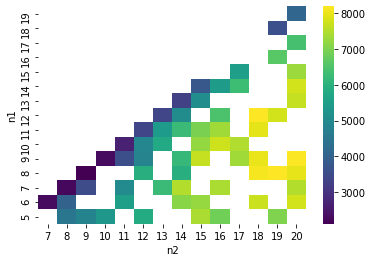

In [7]:
# Parameter heatmap
hm = heatmap.groupby(["n1", "n2"]).mean().unstack()
sns.heatmap(hm[::-1], cmap="viridis")

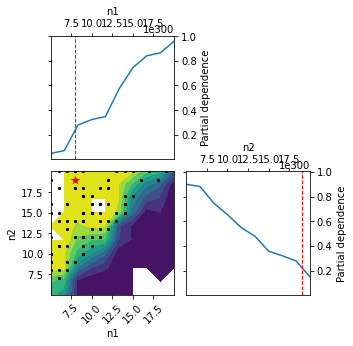

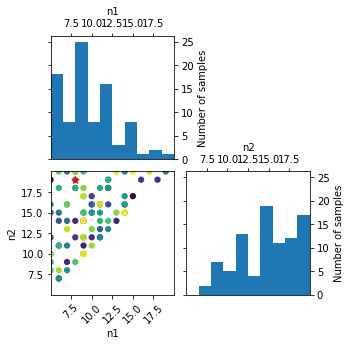

In [8]:
# Plot objective
_ = plot_objective(optim_res, n_points=10)
plt.show()

# Plot evaluations
_ = plot_evaluations(optim_res, bins=10)
plt.show()

In [9]:
# Mean Reversion strategy will be added later.